# Setup - Requires a docker container yuh
```bash
sudo docker run --device=nvidia.com/gpu=all \
                                                      -p 51000:51000 \
                                                      --shm-size 2g \
                                                      -e CLIP_MODEL_NAME=jinaai/jina-clip-v2 \
                                                      -v ~/.cache/huggingface:/root/.cache/huggingface \
                                                      jinaai/clip-server:latest
                                                      
```

In [8]:
import nest_asyncio
nest_asyncio.apply()
import os
import glob
import io
from PIL import Image, UnidentifiedImageError
from docarray import Document, DocumentArray
from clip_client import Client
from dotenv import load_dotenv
from neo4j import GraphDatabase
import numpy as np
import os
from tqdm import tqdm
from datetime import datetime
import pickle
import numpy as np
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from types import SimpleNamespace


c = Client('grpc://172.17.0.8:51000') 

c.profile()

env_path = os.path.expanduser("~/workspace/.env")
load_dotenv(env_path, override=True)
uri = os.getenv("NEO4J_URI")
print(f"Loading from: {env_path}")
print(f"NEO4J_URI found: {uri}") 
if not uri:
    raise ValueError("NEO4J_URI is missing! Check the .env file path.")

driver = GraphDatabase.driver(
    uri,
    auth=(os.getenv("NEO4J_USERNAME"), os.getenv("NEO4J_PASSWORD"))
)

print("Greetz Frenchie + hoeban")

Roundtrip  4ms  100% 
├──  Client-server network  2ms  55% 
└──  Server  2ms  45% 
    ├──  Gateway-CLIP network  1ms  50% 
    └──  CLIP model  1ms  50%

Loading from: /home/jovyan/workspace/.env
NEO4J_URI found: neo4j+s://b66c948d.databases.neo4j.io
Greetz Frenchie + hoeban


In [9]:
image_dir = os.path.expanduser('~/workspace/Datasets/Pictures/')
image_paths = glob.glob(os.path.join(image_dir, '*')) 
valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.webp'}
image_paths = [p for p in image_paths if os.path.splitext(p)[1].lower() in valid_extensions]
print(f"Found {len(image_paths)} images in {image_dir}")

Found 4100 images in /home/jovyan/workspace/Datasets/Pictures/


In [10]:
docs = DocumentArray([Document(uri=path) for path in image_paths])

def data_generator(docs):
    for doc in docs:
        try:
            doc.load_uri_to_blob() 
            with Image.open(io.BytesIO(doc.blob)) as img:
                img.verify() 
            yield doc
            
        except (UnidentifiedImageError, OSError, Exception) as e:
            print(f"Skipping corrupt file: {doc.uri} | Error: {e}")

In [11]:
CACHE_DIR = os.path.expanduser("~/workspace/.cache")
CACHE_FILE = os.path.join(CACHE_DIR, "clip_embeddings_v3.pkl")

os.makedirs(CACHE_DIR, exist_ok=True)
print(f"Cache file: {CACHE_FILE}")

embeddings = None
cache_valid = False

if os.path.exists(CACHE_FILE):
    print("Found cache file. Verifying consistency...")
    try:
        # Phase 1: Unpickle and validate structure
        with open(CACHE_FILE, 'rb') as f:
            cache = pickle.load(f)
        
        # Phase 2: Validate required keys
        required_keys = {'embeddings', 'timestamp', 'num_images'}
        if not all(key in cache for key in required_keys):
            raise ValueError(f"Cache missing required keys. Found: {cache.keys()}")
        
        cached_emb = cache['embeddings']
        
        # Phase 3: Dimensional validation
        if len(cached_emb) != len(docs):
            print(f"Cache dimension mismatch:")
            print(f"   Cache contains: {len(cached_emb)} embeddings")
            print(f"   Current dataset: {len(docs)} images")
            print(f"   Cache will be regenerated to match current dataset size")
        elif cached_emb.shape[1] != 512:
            print(f"Embedding dimension mismatch:")
            print(f"   Expected: 512, Found: {cached_emb.shape[1]}")
            print(f"   This may indicate a model version change")
        else:
            # Phase 4: Successful validation - construct namespace
            embeddings = SimpleNamespace(embeddings=cached_emb)
            cache_valid = True
            print(f"Cache validated successfully!")
            print(f"  - Shape: {embeddings.embeddings.shape}")
            print(f"  - Generated: {cache.get('timestamp', 'unknown')}")
            print(f"  - Images: {cache.get('num_images', 'unknown')}")
            
    except FileNotFoundError:
        print("Cache file disappeared during validation. Will regenerate.")
    except (pickle.UnpicklingError, EOFError) as e:
        print(f"Cache file corrupted: {e}. Will regenerate.")
    except Exception as e:
        print(f"Unexpected cache validation error: {e}")
        print(f"Error type: {type(e).__name__}")
        print("Will regenerate cache to ensure consistency.")

# Encoding phase - only if cache validation failed
if not cache_valid:
    print(f"\n{'='*60}")
    print(f"Encoding {len(docs)} images with CLIP")
    print(f"{'='*60}")
    
    embeddings = c.encode(
        data_generator(docs),
        batch_size=16,
        show_progress=True,
        length=len(docs)
    )
    
    print(f"\n Encoding complete! Shape: {embeddings.embeddings.shape}")
    
    # Persist cache with metadata
    cache_data = {
        'embeddings': embeddings.embeddings,
        'timestamp': datetime.now().isoformat(),
        'num_images': len(docs),
        'embedding_dim': embeddings.embeddings.shape[1],
        'model_name': 'jinaai/jina-clip-v2',
        'cache_version': 'v3'
    }
    
    try:
        with open(CACHE_FILE, 'wb') as f:
            pickle.dump(cache_data, f, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"Cache persisted successfully:")
        print(f"{CACHE_FILE}")
    except Exception as e:
        print(f"Warning: Could not save cache: {e}")
        print(f"   Embeddings are still available for this session")

print(f"\n{'='*60}")
print(f"Ready! Embeddings shape: {embeddings.embeddings.shape}")
print(f"{'='*60}")

Cache file: /home/jovyan/workspace/.cache/clip_embeddings_v3.pkl
Found cache file. Verifying consistency...
✓ Cache validated successfully!
  - Shape: (4100, 512)
  - Generated: 2025-11-27T22:03:05.197435
  - Images: 4100

Ready! Embeddings shape: (4100, 512)


In [12]:

def create_index(tx):
    tx.run("""
        CREATE VECTOR INDEX image_clip_embedding IF NOT EXISTS
        FOR (i:Image) ON (i.embedding)
        OPTIONS {
            indexConfig: {
                `vector.dimensions`: 512,
                `vector.similarity_function`: 'cosine'
            }
        }
    """)

BATCH_SIZE = 500

def upsert_batch(tx, batch):
    tx.run("""
        UNWIND $batch AS row
        MERGE (i:Image {uri: row.uri})
        SET i.filename = row.filename,
            i.embedding = row.embedding,
            i.cached_at = datetime()
    """, batch=batch)

print("Starting migration of cached embeddings Neo4j...")

with driver.session() as session:
    session.execute_write(create_index)
    print("Vector index ready")

    batch = []
    total = len(docs)
    
    for idx, doc in enumerate(tqdm(docs, desc="Uploading to Neo4j", unit="img")):
        uri = getattr(doc, 'uri', None)
        if not uri:
            continue  # skip any broken docs
            
        filename = os.path.basename(uri)
        
        batch.append({
            "uri": uri,
            "filename": filename,
            "embedding": embeddings.embeddings[idx].tolist()  # ← from cache!
        })
        
        if len(batch) >= BATCH_SIZE:
            session.execute_write(upsert_batch, batch)
            batch.clear()
    
    if batch:
        session.execute_write(upsert_batch, batch)

driver.close()
print(f"\nSUCCESS! {total} images are now permanently stored in Neo4j")

Starting migration of cached embeddings Neo4j...
Vector index ready


Uploading to Neo4j: 100%|██████████| 4100/4100 [00:29<00:00, 141.35img/s]



SUCCESS! 4100 images are now permanently stored in Neo4j


Running similarity search for 6 control images 

Query: 1761545212565880.jpg

QUERY: 1761545212565880.jpg
1. 0.8960 → i-wouldnt-be-surprised-if-her-parents-were-death-eaters-v0-o6ccoinpfpzd1.webp
2. 0.8873 → my-favorite-slightly-awkward-harry-potter-promo-pics-v0-0ue1fkgc4pqe1.webp
3. 0.8752 → prisoner-of-azkaban-styling-v0-yqphvbvnva7e1.webp
4. 0.8728 → people-tree-photoshoot-autumn-winter-2010-v0-t3sc4z11fzxf1.webp
5. 0.8710 → le-grand-journal-66th-cannes-film-festival-on-may-17-2013-v0-2o5u0e3oz13e1.webp


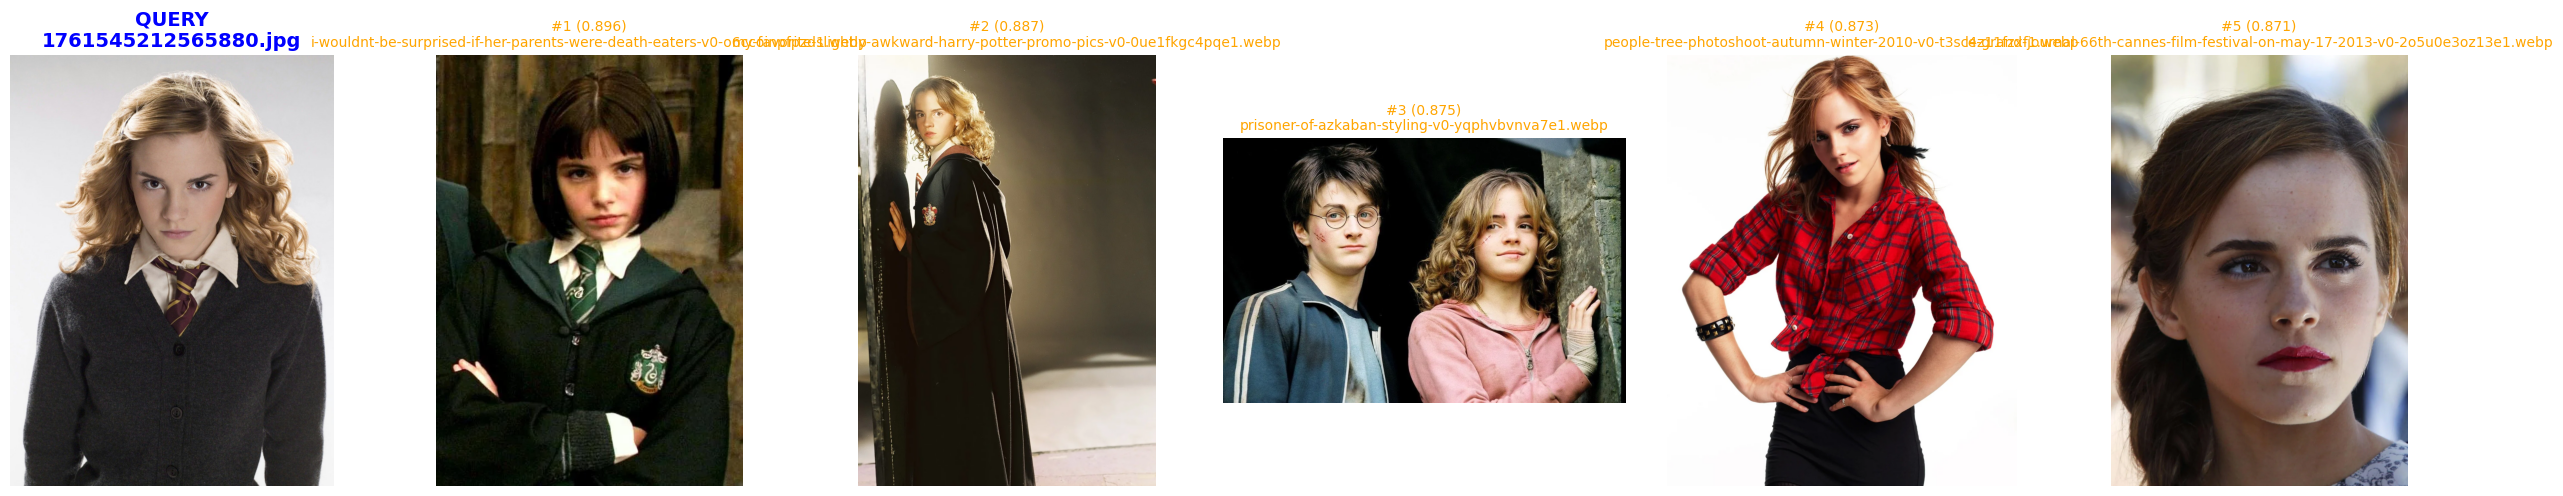

Query: 1763571919384294.jpg

QUERY: 1763571919384294.jpg
1. 0.9498 → 2013-mtv-movie-awards-v0-onfw2i9ewo0e1.webp
2. 0.9114 → 25w4dtoi6wyf1.jpeg
3. 0.9092 → ariana-grande-v0-m2jkt642ib0e1.webp
4. 0.8962 → 2011-glamour-magazine-photoshoot-v0-0kifm87c68qd1.webp
5. 0.8918 → little-ari-random-pics-v0-m29qu9nzxh1g1.webp


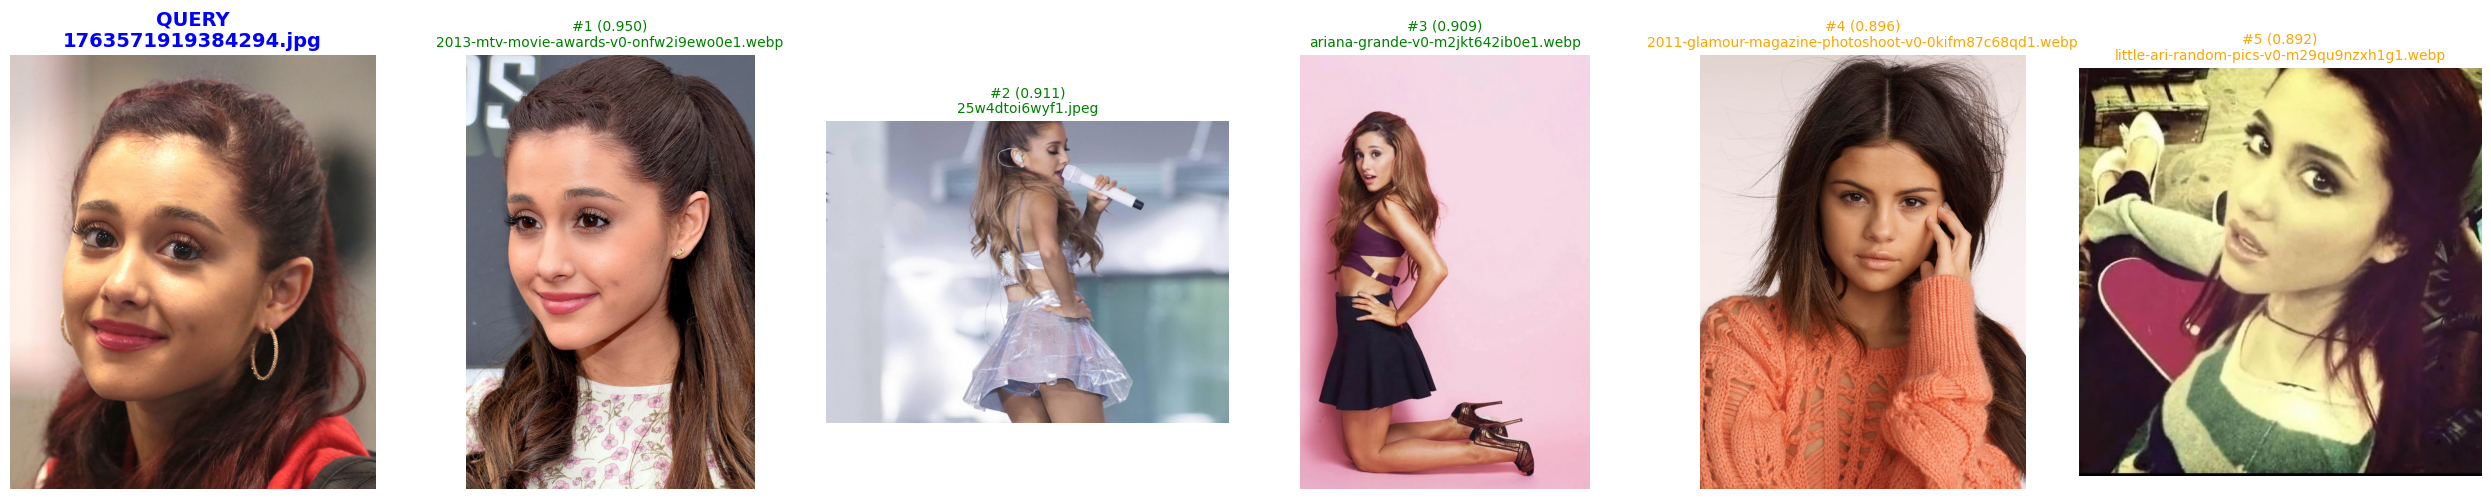

Query: 2008-taylor-swift-tour-v0-whcs3m73r31g1.webp

QUERY: 2008-taylor-swift-tour-v0-whcs3m73r31g1.webp
1. 0.9254 → 2008-taylor-swift-tour-v0-345u2a23r31g1.webp
2. 0.9238 → favorite-photoshoots-deep-cut-v0-5t58874jciff1.webp
3. 0.9165 → taylor-swift-v0-4o3pux3shyzd1.webp
4. 0.9129 → her-expressions-just-love-it-v0-y7mopty63lze1.webp
5. 0.9088 → taylors-red-era-v0-alqvl75jjkhf1.webp


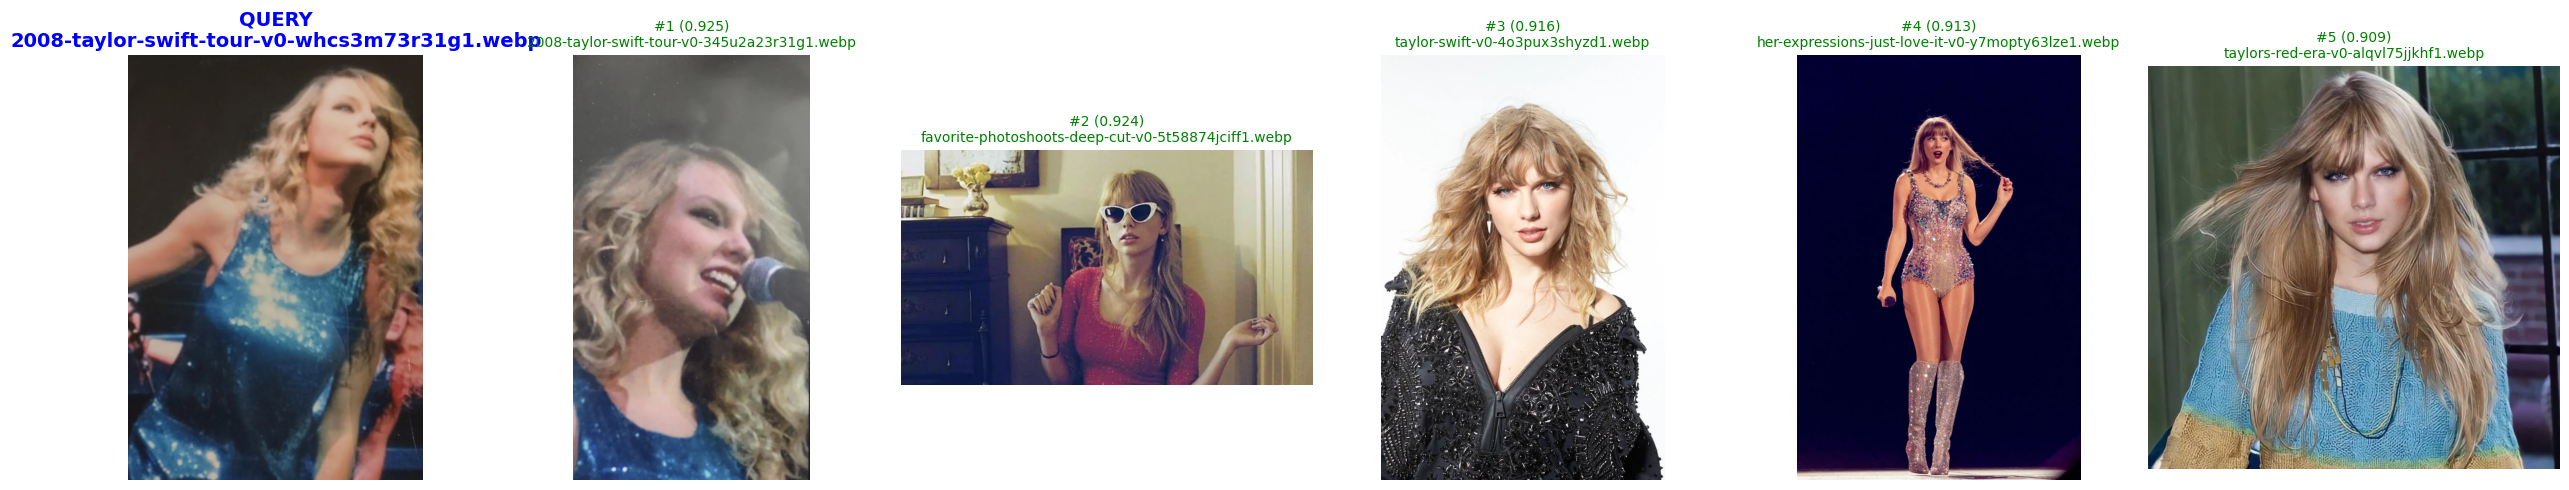

Query: Screenshot 2024-03-02 14-02-26.png

QUERY: Screenshot 2024-03-02 14-02-26.png
1. 0.9405 → Screenshot 2024-03-02 14-02-29.png
2. 0.9298 → Screenshot 2024-03-16 17-33-28.png
3. 0.9149 → Screenshot 2024-03-16 17-34-09.png
4. 0.9067 → Screenshot 2024-03-16 17-34-06.png
5. 0.9030 → Screenshot 2024-03-16 18-02-59.png


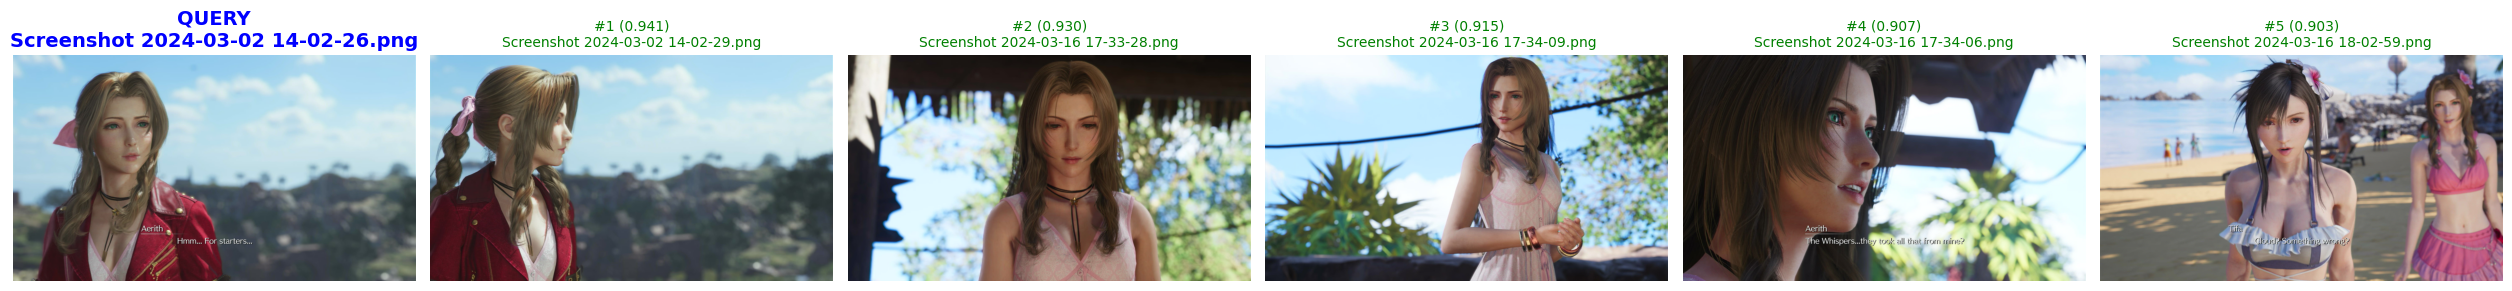

Query: marin-kitagawa-v0-t2dgo4lkppuf1.png

QUERY: marin-kitagawa-v0-t2dgo4lkppuf1.png
1. 0.9756 → marin-kitagawa-v0-t2dgo4lkppuf1.webp
2. 0.9025 → shokuhou-misaki-figure-v0-zwwznsev9hhf1.jpg
3. 0.8859 → from-spiritale-new-marin-kitagawa-swimsuit-ver-1-6-scale-v0-cupsc5e6u39e1.webp
4. 0.8787 → marin-cosplay-prints-v0-384on2h1k90e1.webp
5. 0.8783 → my-dress-up-darling-kitagawa-marin-bunny-resin-figure-ane-v0-w1s4kmedclgf1.jpg


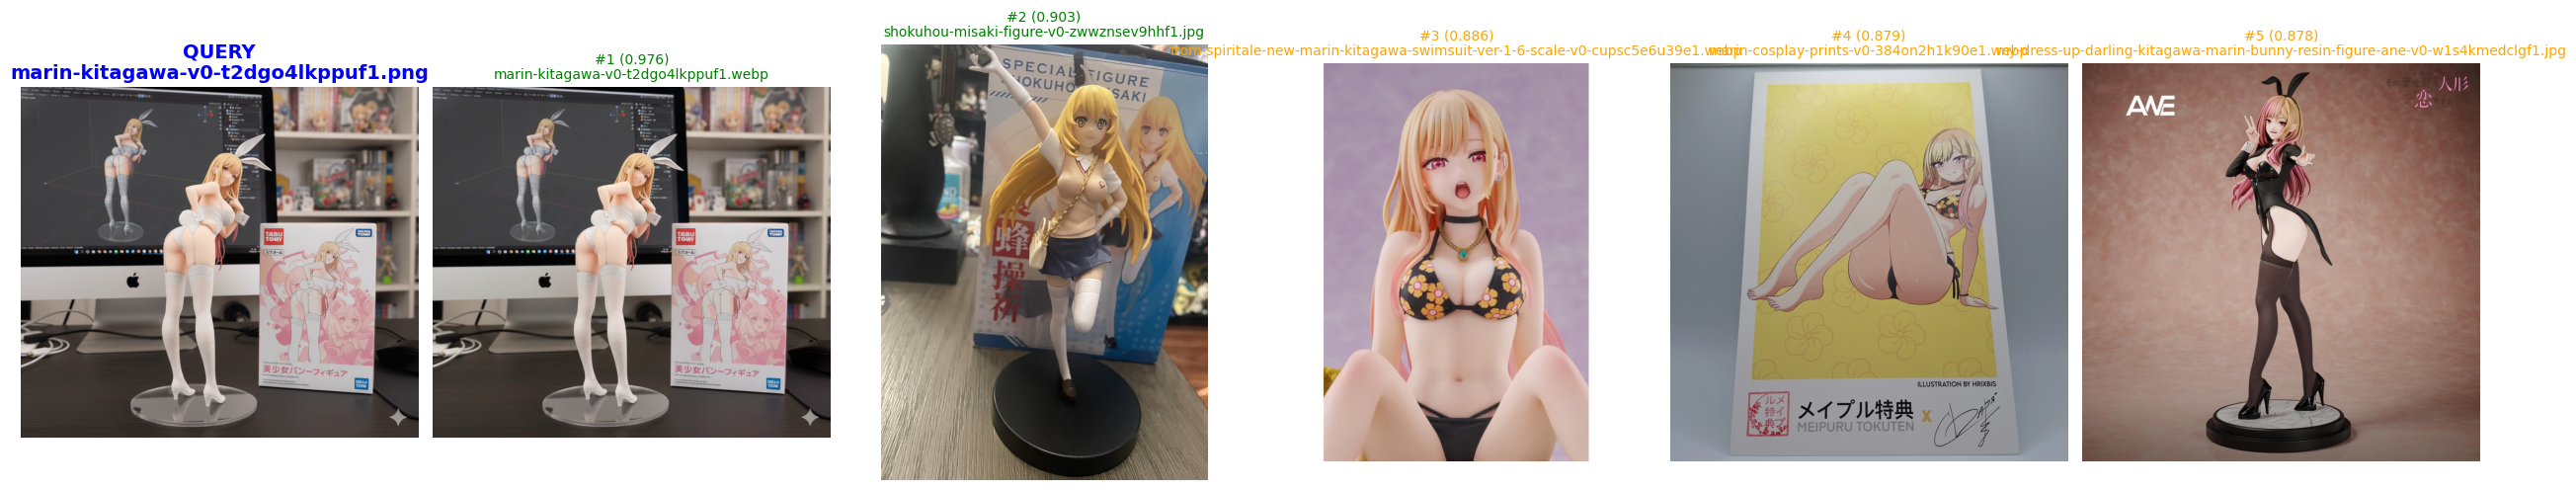

Query: sydsnap (22).jpg

QUERY: sydsnap (22).jpg
1. 0.9397 → sydsnap (15).jpg
2. 0.9278 → sydsnap (5).jpg
3. 0.9251 → sydsnap (26).jpg
4. 0.9215 → sydsnap (1).jpg
5. 0.9120 → sydsnap (28).jpg


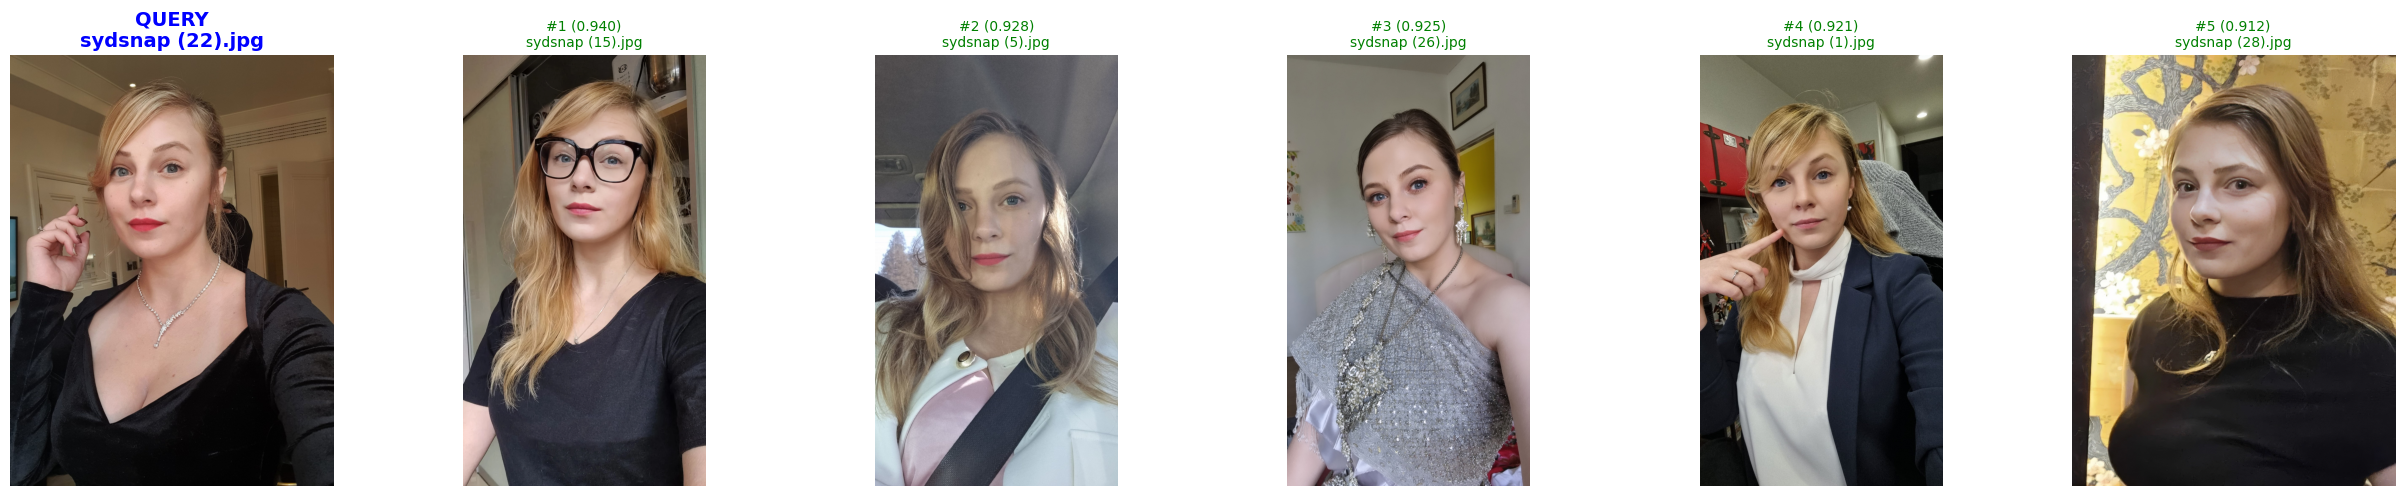


DONE.


In [13]:
uri = os.getenv("NEO4J_URI")

driver = GraphDatabase.driver(
    uri,
    auth=(os.getenv("NEO4J_USERNAME"), os.getenv("NEO4J_PASSWORD"))
)

control_dir = os.path.expanduser('~/workspace/Datasets/Pictures/Control/')
control_paths = sorted([
    os.path.join(control_dir, f)
    for f in os.listdir(control_dir)
    if not f.startswith('.')
])

TOP_K = 5
print(f"Running similarity search for {len(control_paths)} control images \n")

for query_path in control_paths:
    query_name = os.path.basename(query_path)
    print(f"Query: {query_name}")

    # Encode query (works with both clip-client versions)
    result = c.encode([query_path])
    query_vector = result[0].tolist() if isinstance(result, np.ndarray) else result.embeddings[0].tolist()

    # Search Neo4j
    with driver.session() as session:
        raw_results = session.run("""
            CALL db.index.vector.queryNodes('image_clip_embedding', 50, $vec)
            YIELD node, score
            RETURN node.uri AS uri, score
            ORDER BY score DESC
        """, vec=query_vector).data()

    # REMOVE SELF-MATCHES & NEAR-DUPLICATES
    clean_matches = []
    for r in raw_results:
        if r['uri'] == query_path:          # exact same file
            continue
        if r['score'] > 0.999:              # near-perfect duplicate
            continue
        clean_matches.append(r)
        if len(clean_matches) >= TOP_K:
            break

    # Fallback: if nothing found, show top non-exact matches
    if not clean_matches:
        clean_matches = [r for r in raw_results[:TOP_K] if r['uri'] != query_path]

    # Debug print
    print(f"\n{'='*85}")
    print(f"QUERY: {query_name}")
    print(f"{'='*85}")
    for i, m in enumerate(clean_matches):
        print(f"{i+1}. {m['score']:.4f} → {os.path.basename(m['uri'])}")

    # Visual grid
    cols = len(clean_matches) + 1
    fig, axes = plt.subplots(1, cols, figsize=(4.2 * cols, 5))
    if cols == 1:
        axes = [axes]

    # Query image
    try:
        img = mpimg.imread(query_path)
        axes[0].imshow(img)
        axes[0].set_title(f"QUERY\n{query_name}", color='blue', fontsize=14, fontweight='bold')
    except Exception as e:
        axes[0].text(0.5, 0.5, f"ERROR\n{e}", color='red', ha='center')
    axes[0].axis('off')

    # Real matches
    for i, m in enumerate(clean_matches):
        ax = axes[i+1]
        try:
            img = mpimg.imread(m['uri'])
            ax.imshow(img)
            score = m['score']
            color = 'green' if score >= 0.90 else ('orange' if score >= 0.80 else 'black')
            ax.set_title(f"#{i+1} ({score:.3f})\n{os.path.basename(m['uri'])}",
                        color=color, fontsize=10)
        except:
            ax.text(0.5, 0.5, "NO IMG", color='red', ha='center')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

driver.close()
print("\nDONE.")